In [61]:
import numpy as np
from numpy import pi, cos, sin, log, exp
from scipy.stats import ortho_group, multivariate_normal, wishart

from matplotlib import pyplot as plt
from matplotlib import cm

Synthetic data generation

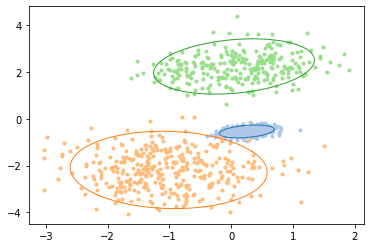

In [77]:
D = 2
K = 3
N = 1000

p = np.random.rand(K)
p = p/p.sum()
p = np.sort(p)[::-1]

mu = np.random.randn(K,D)

U = ortho_group.rvs(D,K)
L = np.random.rand(K,D)
S = np.array([np.linalg.multi_dot([U[k],np.diag(L[k]),U[k].T]) for k in range(K)])

Z = np.random.choice(K, N, p=p)
X = np.array([np.random.multivariate_normal(mu[z],S[z]) for z in Z])

cmap = cm.tab20

Y0 = np.array([[cos(t), sin(t)] for t in np.linspace(0,2*pi,100)])

for k in range(K):
    idx = (Z==k)
    plt.plot(X[idx,0], X[idx,1], '.', color=cmap(2*k+1))
    
    Y = 2*np.linalg.multi_dot([Y0, np.diag(L[k]**(1/2)), U[k].T]) + mu[k]
    plt.plot(Y[:,0], Y[:,1], color=cmap(2*k), lw=1)
plt.show()

In [78]:
def EM_Gauss(X, K, T, thres=1e-6):
    N = X.shape[0]
    D = X.shape[1]
    m0 = X.mean(0)
    s0 = np.cov(X.T)
    A0 = np.linalg.cholesky(s0)
    
    p = np.zeros((T,K))
    gamma = np.zeros((T,K,N))
    mu = np.zeros((T,K,D))
    S = np.zeros((T,K,D,D))
    E = np.zeros(T) # negative of log-likelihood
    
    pdf = np.zeros((K,N))
    def pdf_eval(t):
        pdf[:] = np.array([p[t,k]*multivariate_normal.pdf(X, mu[t,k], S[t,k]) for k in range(K)])
    
    def gamma_eval(t):
        gamma[t] = pdf / pdf.sum(0)

    def E_eval(t):
        E[t] = -log(pdf.sum(0)).sum()
    
    def lazy_atomic(t):
        pdf_eval(t)
        gamma_eval(t)
        E_eval(t)
    
    p[0] = np.random.rand(K)
    p[0] /= p[0].sum()
    mu[0] = np.random.randn(K,D).dot(A0.T) + m0
    S[0] = wishart.rvs(D,s0,K)
    lazy_atomic(0)

    for t in range(T-1):
        Nk = gamma[t].sum(1)
        p[t+1] = Nk/N
        mu[t+1] = gamma[t].dot(X)/Nk.reshape(-1,1)
        for k in range(K):
            Y = X-mu[t+1,k]
            S[t+1,k] = (gamma[t,k]*(Y.T)).dot(Y)/Nk[k]
        lazy_atomic(t+1)
       
        if abs((E[t+1]-E[t])/E[t]) < thres:
            T = t+2
            print(f'Converge @ iter #{t}')
            break

    return gamma[:T], p[:T], mu[:T], S[:T], E[:T], T

In [90]:
K_est = np.arange(6)

gamma_est, p_est, mu_est, S_est, E, T = EM_Gauss(X, K, 2000)
Z_est = gamma_est.argmax(1)

Converge @ iter #19


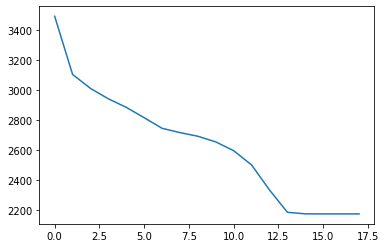

In [80]:
plt.plot(E)
plt.show()

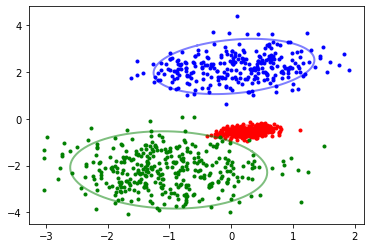

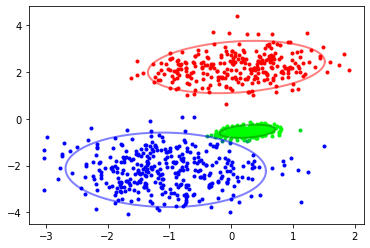

In [81]:
Y0 = np.array([[cos(t), sin(t)] for t in np.linspace(0,2*pi,100)])

color=['r','g','b']

for k in range(K):
    idx = (Z==k)
    plt.plot(X[idx,0], X[idx,1], '.', color=color[k])
    
    Y = 2*np.linalg.multi_dot([Y0, np.diag(L[k]**(1/2)), U[k].T]) + mu[k]
    plt.plot(Y[:,0], Y[:,1], color=color[k], alpha=0.5, lw=2)

plt.show()

for n in range(N):
    plt.plot(X[n,0], X[n,1], '.', color=gamma_est[-1,:,n])

for k in range(K):
    A = np.linalg.cholesky(S_est[-1,k])
    
    Y = 2*Y0.dot(A.T) + mu_est[-1,k]
    plt.plot(Y[:,0], Y[:,1], color=color[k], alpha=0.5, lw=2)

plt.show()

In [160]:
def EM_Gauss_inc_simulation(p0, mu0, S0, N0=1000, thres=1e-6, streak=100):
    # Each data point is processed and tossed
    # No update on gamma
    # Z,X,dE is used for analysis and visualization
    K = mu0.shape[0]
    D = mu0.shape[1]

    # State variables
    N = N0
    Z = np.zeros(N,dtype=int)
    X = np.zeros((N,D))
    dE = np.zeros(N) # negative of log-likelihood
    
    Nk = np.zeros(K)
    p = np.zeros(K)
    mu = np.zeros((K,D))
    S = np.zeros((K,D,D))
    
    # Generate N0 points for initialization
    Z0 = np.random.choice(K, N0, p=p0)
    X0 = np.array([multivariate_normal.rvs(mu0[z],S0[z]) for z in Z0])
    m0 = X0.mean(0)
    s0 = np.cov(X0.T)
    A0 = np.linalg.cholesky(s0)
    
    p[:] = np.random.rand(K)
    p /= p.sum()
    Nk = p*N0
    mu[:] = np.random.randn(K,D).dot(A0.T) + m0
    S[:] = wishart.rvs(D,s0,K)
    
    n = 0
    counter = 0
    while True:
        Z[n] = np.random.choice(K,p=p0)
        X[n] = multivariate_normal.rvs(mu0[Z[n]],S0[Z[n]])
        
        pdf_pre = np.array([p[k]*multivariate_normal.pdf(X[n], mu[k], S[k]) for k in range(K)])
        E_pre = log(pdf_pre.sum())
        gamma = pdf_pre / pdf_pre.sum()
        
        Nk += gamma
        mu += gamma.reshape(-1,1)*(X[n]-mu)/Nk.reshape(-1,1)
        for k in range(K):
            y = X[n] - mu[k]
            S[k] += gamma[k]*(np.outer(y,y)-S[k])/Nk[k]
        p += gamma/(n+1)
        
        pdf_post = np.array([p[k]*multivariate_normal.pdf(X[n], mu[k], S[k]) for k in range(K)])
        E_post = log(pdf_post.sum())
        dE[n] = E_post - E_pre
        if dE[n] > thres:
            counter = 0
        elif counter == streak:
            N = n+1
            print(f'Converge @ sample #{N}')
            break
        else:
            counter += 1
        
        n += 1
        if n == N:
            print(f'Number of samples: {N}, dE={dE[-1]}')
            N = int(1.5*N)
            Z.resize(N)
            X.resize((N,D))
            dE.resize(N)

    return p, mu, S, X[:N], Z[:N], dE[:N]

In [162]:
p_est, mu_est, S_est, X_samp, Z_samp, dE_samp = EM_Gauss_inc_simulation(p, mu, S, thres=1e-3)

Number of samples: 1000, dE=0.0013209841162595826
Number of samples: 1500, dE=0.000613784354402791
Number of samples: 2250, dE=0.0005544193774735806
Number of samples: 3375, dE=0.00033304952337394333
Number of samples: 5062, dE=0.0007580733168530696
Number of samples: 7593, dE=0.00015642291627371296
Number of samples: 11389, dE=0.00010698914038809182
Number of samples: 17083, dE=0.0005159798006186822
Converge @ sample #20334


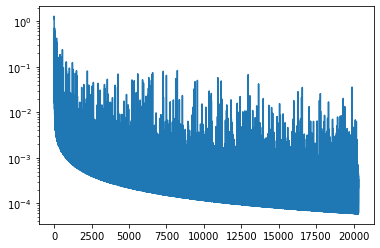

In [163]:
plt.plot(dE_samp[:])
plt.yscale('log')

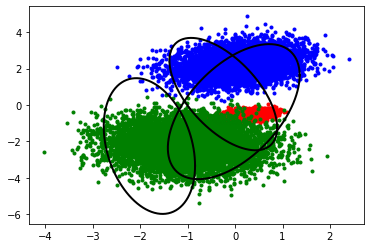

In [166]:
Y0 = np.array([[cos(t), sin(t)] for t in np.linspace(0,2*pi,100)])

color=['r','g','b']

for k in range(K):
    idx = (Z_samp==k)
    plt.plot(X_samp[idx,0], X_samp[idx,1], '.', color=color[k])
    
    #Y = 2*np.linalg.multi_dot([Y0, np.diag(L[k]**(1/2)), U[k].T]) + mu[k]
    #plt.plot(Y[:,0], Y[:,1], color=color[k], alpha=0.5, lw=2)

# plt.show()
# 
#for n in range(N):
#    plt.plot(X_samp[n,0], X_samp[n,1], '.', color=color[k]) #color=gamma_est[-1,:,n])

for k in range(K):
    A = np.linalg.cholesky(S_est[k])
    
    Y = 2*Y0.dot(A.T) + mu_est[k]
    plt.plot(Y[:,0], Y[:,1], color='k', lw=2)

plt.show()